### This is a stripped down version of the Picture Artifier notebook, you need to select style image manualy but you can still see how the style transfer works with the style patches selected based on the cosine similarity.

Put paths to your images here and run all the cells.

In [2]:
content_path = 'results/deathstar_cont.jpg'
style_path = 'results/deathstar_style.jpg'

### All the helper functions scroll down for results

In [3]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import math
import operator
from PIL import Image

In [4]:
# Function for visualizing images works on a tensor or list of tensors
def show_all(images, captions=[], title=None):
    img_n = len(images)
    cols = min(4, img_n)
    rows = (img_n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(8 * cols,8 * rows))
    fig.suptitle(title)
    if len(images) > 1: axs = axs.flatten()
    else: axs = [axs]
    for idx, img in enumerate(images):
        ax = axs[idx]
        ax.imshow(tensor2img(img))
        ax.axis('off')
        if idx < len(captions):
            ax.set_title(captions[idx])

    plt.close()
    return fig

# Saves experiment result to a file, takes three tensors for content, style and the result
def save_result(name, images):
    suf = ['cont', 'style', 'res']
    for im,sf in zip(images, suf):
        fname = f'results/{name}_{sf}.jpg'
        plt.imsave(fname, tensor2img(im))

In [5]:
# Runs a tensor through all the vgg layers up to the given index
def get_activations(input, vgg_idx):
    net = nn.Sequential(*list(vgg.children())[:vgg_idx+1])
    return net(input)

In [6]:
# The losses
def style_loss(img, gram_tar):
    gram_img = gram_matrix(img)
    return matrix_diff(gram_img, gram_tar)

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, -1).clone()
    gram = torch.mm(tensor, tensor.t())
    return gram / (h * w)

def tv_loss(X):
    return ((X[:,:-1,:] - X[:,1:,:]) ** 2).sum() + ((X[:,:,:-1] - X[:,:,1:]) ** 2).sum()

def content_loss(img, tar):
    return matrix_diff(img, tar)

def matrix_diff(m, m_tar):
    diff = (m - m_tar) ** 2
    return torch.mean(diff) * 10000 # Squaring small numbers gives very small numbers. Scaling it by a constant for readability and float precision

In [7]:
# training loop, backpropagates through pixel values of the image to minimize the sum or style, content and variation losses
def train(img_x, content_target, content_idx, style_targets, epochs = 500, content_mul=1e-5 ):
    img_x.requires_grad = True
    opt = optim.Adam([img_x], lr=0.01)
    style_idxs = list(style_targets.keys())
    last_layer = max(style_idxs + [content_idx])
    model_layers = list(vgg.children())[:last_layer+1]
    
    w_tv = 1e-9
    for st in range(epochs):
        style_lss = torch.tensor(0.0).cuda()
        content_lss = torch.tensor(0.0).cuda()
        x = img_x
        for idx, layer in enumerate(model_layers):
            x = layer(x)
            if idx == content_idx:
                content_lss +=  content_loss(x, content_target) * content_mul
            if idx in style_idxs:
                style_lss += style_loss(x, style_targets[idx])
        if st %50 == 49:
            display.clear_output(wait=True)
            display.display(show_all([img_x], [f'lss: {content_lss :.3f}, {style_lss :.3f}, {tv_lss :.3f}'], f'epoch {st}'))
        tv_lss = tv_loss(img_x) * w_tv
        lss = style_lss + content_lss + tv_lss
        opt.zero_grad()
        lss.backward()
        opt.step() 

In [8]:
# for each position in the layer concatenates its activations with the activations at the 8 surrounding postions
def add_neighbours(a):
    a = a.squeeze() # (chan, h, w)
    c,h, w = a.shape
    pada = F.pad(a, [1,1,1,1,0,0])
    b = torch.zeros(9,c,h,w, device = a.get_device())
    p=0
    for i in range(-1,2):
        for j in range(-1,2):
            b[p] = pada[:,1+i:h+1+i, 1+j:w+1+j]
            p+=1
    return b #(9,c, h, w)

# for each row in matrix X finds the most similar row in matrix Y, according to cosine similarity
def cosine_nearest(x, y): #h*w x 9*ch
    res = torch.empty([x.shape[0]], dtype=torch.int64).cuda()
    batch_size = 500
    total_dist =0
    for idx in range(0, len(res), batch_size):
        batch_end = min(len(res), idx + batch_size)
        batch = slice(idx, batch_end)
        bx = x[batch,:]
        res[batch],dist = cosine_batch(bx,y)
        total_dist += dist
    return res, total_dist

def cosine_batch(x, y):
    scals = torch.mm(x, y.t())
    x_norm = torch.sqrt(x**2).sum(1).view(-1, 1)
    y_norm = torch.sqrt(y**2).sum(1).view(1, -1)
    xy = torch.mm(x, y.t())
    dist = scals / (1e-8 + x_norm * y_norm)
    maxs, max_idxs = dist.max(dim=1)
    return max_idxs, maxs.sum()

# stiches an image from indices selected from a vgg layer maxpooled mult times
def reconstruct(style, min_idxs, mult, ch, cw, sh, sw):
    upscaled = torch.empty_like(content)
    lxs, lys = torch.meshgrid([torch.arange(0,ch, dtype=torch.int64), torch.arange(0,cw, dtype=torch.int64)])
    lxs = lxs.contiguous().view(-1)
    lys = lys.contiguous().view(-1)
    rxs, rys = torch.meshgrid([torch.arange(0,sh, dtype=torch.int64), torch.arange(0,sw, dtype=torch.int64)])
    rxs = rxs.contiguous().view(-1)
    rys = rys.contiguous().view(-1)
    
    rxs = rxs[min_idxs]
    rys = rys[min_idxs]
    for i in range(mult):
        for j in range(mult):
            upscaled[:,:,lxs * mult + i,lys * mult + j] = style[:, :, mult * rxs + i, mult * rys + j]
    return upscaled

# finds a mapping of nearest patches between the content and style activations
def get_nearest_idxs(content_act, style_act):
    _, chan, ch, cw = content_act.shape
    _, chan, sh, sw = style_act.shape
    img_neighb,style_neighb = content_act, style_act

    A = img_neighb.view(-1, ch*cw ).t()  # (h * w, 9 * chan)
    B = style_neighb.view(-1, sh*sw).t()
    max_idxs, dist = cosine_nearest(A,B) #h*w
    return max_idxs, dist

# First maps style into content based on the activations and then uses that to reconstruct matching pixels.
def get_nearest_style(content_act, style_act, style_img):  #(1, chan, h, w)
    _, chan, sh, sw = style_act.shape
    _, chan, ch, cw = content_act.shape
    min_idxs,_ = get_nearest_idxs(content_act, style_act)
    targets = style_act.view(chan, sh*sw)[:,min_idxs]
    targets = targets.view(1,chan,ch,cw)
    dist = torch.sum((content_act-targets)**2)
    mult = style.shape[2] //style_act.shape[2]
    upscaled = reconstruct(style_img, min_idxs, mult, ch, cw, sh, sw)
    return upscaled, targets, dist

In [9]:
#Helper functions for loading images, converting them to tensors and back
normalize_params = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
def img2tensor(image, size = None):
    tfms = [
            transforms.ToTensor(),
            transforms.Normalize(*normalize_params)]
    if size is not None:
        tfms.insert(0, transforms.Resize(size))
    image = transforms.Compose(tfms)(image)  
    return image[None].type(torch.FloatTensor).cuda()

def tensor2img(tensor):
    image = tensor.data.cpu().squeeze().numpy()
    image = image.transpose(1,2,0)
    image = image * np.array(normalize_params[1]) + np.array(normalize_params[0])
    image = image.clip(0, 1)

    return image

def load_image(img_path, max_size=512):
    image = Image.open(img_path).convert('RGB')
    image = img2tensor(image, max_size)
    # discard the transparent, alpha channel 
    image = image[:,:3,:,:]
    return image

In [10]:
# for a set of indices in a layer, computes the set of corresponing indices before the MaxPool2d(2,2)
def upscale_idx(idxs, cur_h, cur_w):
    new_h = cur_h * 2
    new_w = cur_w * 2
    idxs_x = idxs / cur_w
    idxs_y = idxs % cur_w
    new_x = idxs_x * 2
    new_y = idxs_y * 2
    all_x = torch.stack([new_x, new_x+1, new_x, new_x+1] ).view(-1)
    all_y = torch.stack([new_y, new_y, new_y+1, new_y+1] ).view(-1)
    return all_x * new_w + all_y

### We are using pretrained VGG16 network with batchnorm in addition to conv and relu layers

In [11]:
vgg = models.vgg16_bn(pretrained=True).features.cuda().eval()
# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [12]:
# Index all the layers with strings for convinience
l_idx =1 
l_d = 1
layer_id2idx ={}
for idx, layer in enumerate(vgg.children()):
    layer_id = f'{l_d}_{l_idx}'
    layer_id2idx[layer_id] = idx
    print(layer_id + ':', layer)
    if isinstance(layer, nn.MaxPool2d):
        l_d +=1
        l_idx = 1
    else:
        l_idx +=1

1_1: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1_2: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
1_3: ReLU(inplace)
1_4: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1_5: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
1_6: ReLU(inplace)
1_7: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
2_1: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2_2: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2_3: ReLU(inplace)
2_4: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2_5: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2_6: ReLU(inplace)
2_7: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
3_1: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3_2: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tra

In [13]:
net53 = nn.Sequential(*list(vgg.children())[:layer_id2idx['5_3']+1])

### The content image

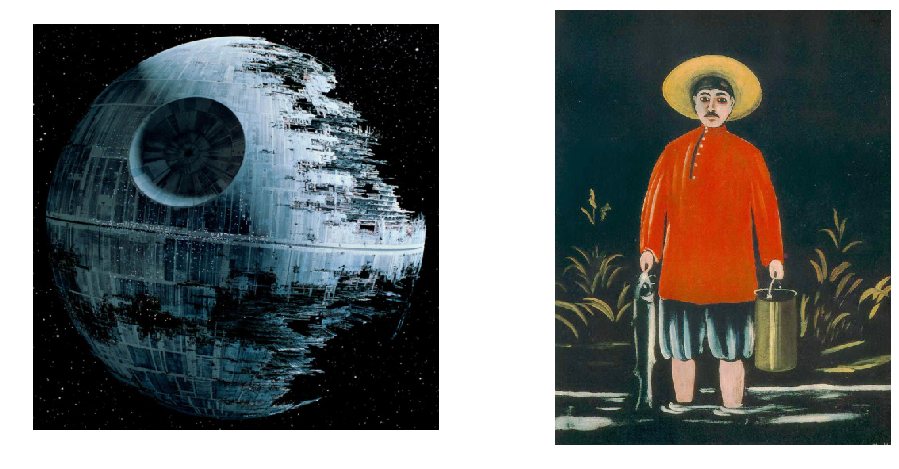

In [14]:
content=load_image(content_path)
style=load_image(style_path)
show_all([content,style])

### Deconstructing the style image and patching it into something that looks like the content

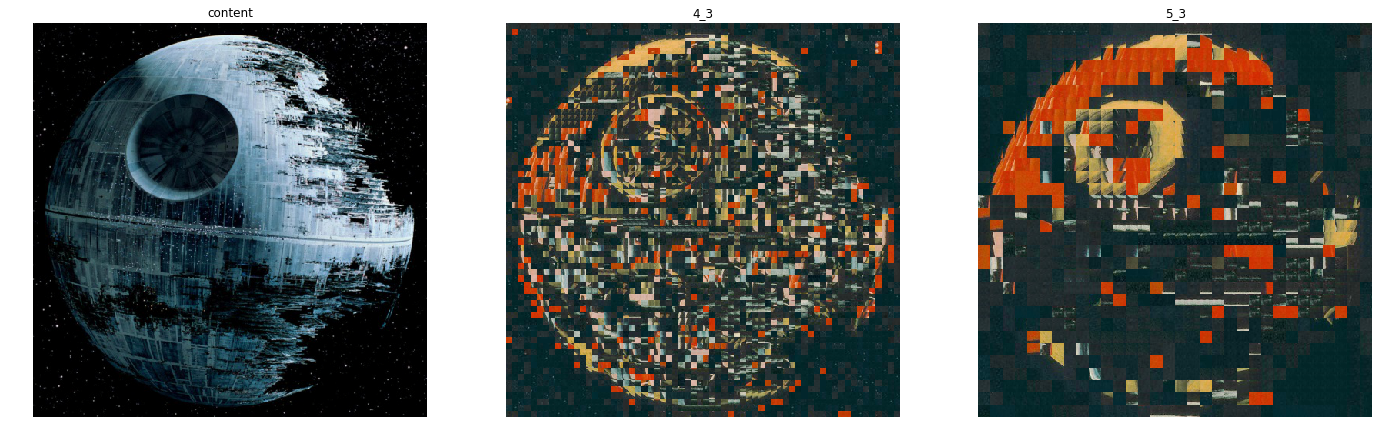

In [15]:
style_layers = ['4_3','5_3']
imgs = []
for layer in style_layers:
    l_idx = layer_id2idx[layer]
    content_act = get_activations(content, l_idx)
    style_act = get_activations(style, l_idx)
    img, target,_ = get_nearest_style(content_act, style_act, style)
    imgs.append(img)
show_all([content] + imgs, captions = ['content'] + style_layers)

### Average or the reconstructed style images

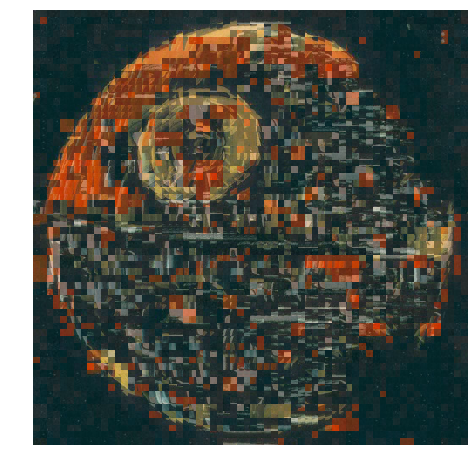

In [16]:
img_x = torch.stack(imgs).sum(dim=0)/(len(imgs))
show_all(img_x)

In [17]:
ref_layer = '4_3' # layer from which we select indices to use for the style loss
content_idx =layer_id2idx[ref_layer]
content_target = get_activations(content, content_idx)
style_act = get_activations(style, layer_id2idx[ref_layer])
min_idxs, _ = get_nearest_idxs(content_act, style_act)
style_targets={}

In [18]:
uniq_idxs = torch.unique(min_idxs) # we use a single copy of each activation vector for Gram matrices
target_activ = style_act.view(style_act.shape[1],-1)[:,uniq_idxs]
style_targets[layer_id2idx[ref_layer]] = torch.mm(target_activ, target_activ.t()) / target_activ.shape[1]

In [19]:
cur_h, cur_w = style_act.shape[2:]
for layer in ['3_3', '2_3','1_3']:
    layer_id = layer_id2idx[layer]
    style_act = get_activations(style, layer_id)
    uniq_idxs = upscale_idx(uniq_idxs, cur_h,cur_w)
    target_activ = style_act.view(style_act.shape[1],-1)[:,uniq_idxs]
    style_targets[layer_id] = torch.mm(target_activ, target_activ.t()) / target_activ.shape[1]
    cur_h, cur_w = cur_h * 2, cur_w * 2

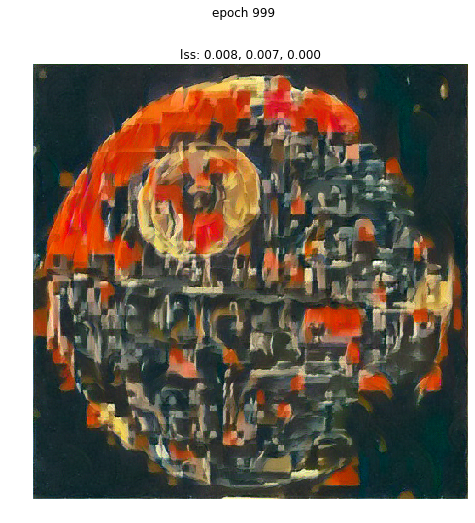

CPU times: user 2min 23s, sys: 54.8 s, total: 3min 18s
Wall time: 3min 19s


In [20]:
%%time 
train(img_x,content_target, content_idx, style_targets, epochs = 1000, content_mul = 1e-4)

# Result

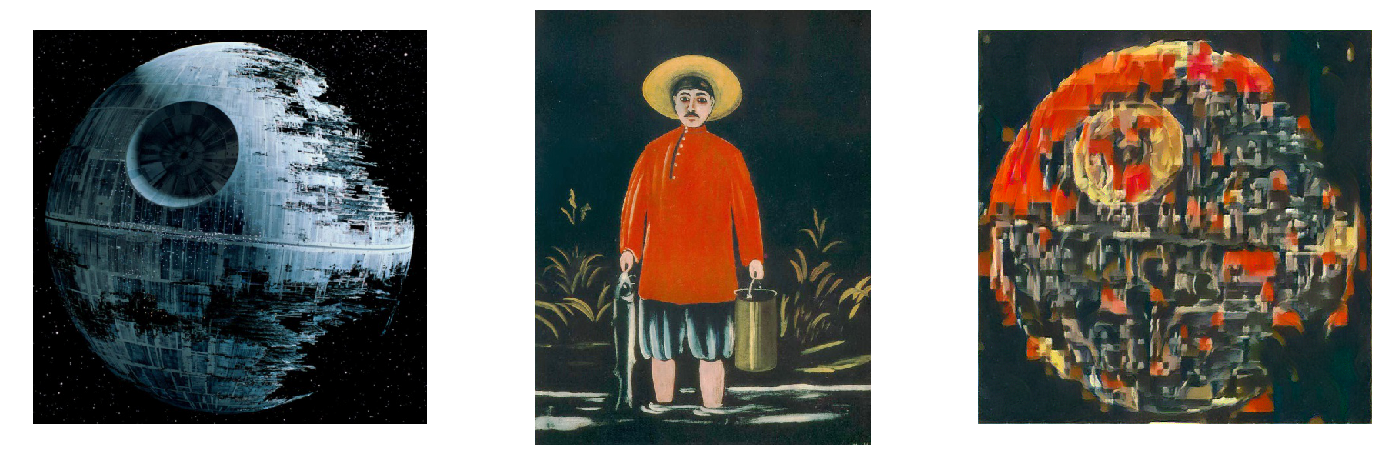

In [21]:
show_all([content,style,img_x])
#save_result('deathstar',[content,style,img_x])
